# Оценка результата проведения A/B-теста

**Цель проекта**: проведение оценки корректности проведения и полученных результатов A/B-теста.

**Заказчик**: Интернет-магазин, разрабатывающий новую систему рекомендаций для пользователей.

**Этапы реализации проекта:** 

[1. Подготовительный этап: загрузка библиотек, выгрузка данных, изучение общей информации о датафреймах, предобработка данных](#general)
- [1.1. Загрузка библиотек, выгрузка данных, изучение общей информации о датафреймах](#general)

- [1.2. Предобработка данных](#preprocessing)

- [1.3. Вывод по этапу](#first_conclusion)



[2. Оценка корректности проведения теста](#ab_estimation)

- [2.1. Проверка соответствия требованиям технического задания, пересечения с маркетинговыми событиями и другим тестом](#specification_check)

- [2.2. Вывод по этапу](#second_conclusion)


[3. Проведение исследовательского анализа данных](#eda)

- [3.1. Распределение количества событий на пользователя в выборках](#eda_events)

- [3.2. Распределение числа событий по дням](#eda_dates)

- [3.3. Изменение конверсии в воронке в выборках на разных этапах](#eda_conv)

- [3.4. Особенности данных перед проведением A/B-тестирования, вывод по разделу](#third_conclusion)


[4. Оценка результатов A/В-тестирования](#results)

- [4.1. Выводы о характере результатов A/В теста](#ab_results)

- [4.2. Проверка статистической разницы долей z-критерием](#test_st_diff)


[5. Выводы](#conclusion)

<a id="first_stage"> </a>
## Подготовительный этап: загрузка библиотек, выгрузка данных, изучение общей информации о датафреймах, предобработка данных

<a id="general"> </a>
### Загрузка библиотек, выгрузка данных, изучение общей информации о датафреймах

In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from scipy import stats as st
from plotly import graph_objects as go
import plotly.express as px
import math as mth
import statistics as sts

In [81]:
#создадим переменную, в которую поместим палитру для графиков
#установим тему для графиков

palette = sns.cubehelix_palette(start=.3, rot=-.6, n_colors=15)
sns.set_theme(style="whitegrid", palette=palette)

In [82]:
#установим ширину отображения столбцов

pd.options.display.max_colwidth = 120

In [83]:
#выгружаем датасеты 

try: 
        schedule, users, events, participants = (
        pd.read_csv('C:/datasets/fp_ab/ab_project_marketing_events.csv'),  #календарь событий
        pd.read_csv('C:/datasets/fp_ab/final_ab_new_users.csv'),  #пользователи
        pd.read_csv('C:/datasets/fp_ab/final_ab_events.csv'), #события
        pd.read_csv('C:/datasets/fp_ab/final_ab_participants.csv') #участники
    )

except:
    schedule, users, events, participants = (
        pd.read_csv('/datasets/ab_project_marketing_events.csv'), #календарь событий
        pd.read_csv('/datasets/final_ab_new_users.csv'), #пользователи
        pd.read_csv('/datasets/final_ab_events.csv'), #события
        pd.read_csv('/datasets/final_ab_participants.csv') #участники
    )
    

In [84]:
#выведем строки датафрейма schedule

schedule.head(5)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


Структура датафрейма `schedule` — календарь маркетинговых событий на 2020 год:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

In [85]:
#выведем строки датафрейма users

users.head(5)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


Структура датафрейма `users` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

In [86]:
#выведем строки датафрейма events

events.head(5)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


Структура датафрейма `events` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года:
- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

In [87]:
#выведем строки датафрейма participants

participants.head(5)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


Структура датафрейма `participants` — таблица участников тестов:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

In [88]:
#выведем общую информацию о таблицах 

display('info schedule', schedule.info())
display('info users', users.info())
display('info events', events.info())
display('info participants', participants.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


'info schedule'

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


'info users'

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


'info events'

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


'info participants'

None

Характеристики датафреймов:

1) Различная размерность: `schedule` имеет 14 строк, `users` - 61733 строк, `events` - 440317 строк, `participants` - 18268 строк.

2) Практически все столбцы имеют тип `object`, исключение - столбец `details` датасета  `events` с типом данных числа с плавающей точкой. Следовательно, несколько столбцов с информацией о дате и времени необходимо привести к временному типу.

3) В трех датафреймах количество данных в каждом из столбцов совпадает, т.е. отсутствуют пропуски. Столбец `details` датасета  `events` имеет существенно меньше данных, чем в остальной таблице.

<a id="preprocessing"> </a>
### Предобработка данных

In [89]:
#создадим для удобства список и словарь датафреймов

df_list = [schedule, events, users, participants]
df_dict = {'schedule': schedule,
           'events': events,
           'users': users,
           'participants': participants}

In [90]:
#ознакомимся с наименованиями столбцов 

for df in df_dict:
    display(df, df_dict[df].columns)

'schedule'

Index(['name', 'regions', 'start_dt', 'finish_dt'], dtype='object')

'events'

Index(['user_id', 'event_dt', 'event_name', 'details'], dtype='object')

'users'

Index(['user_id', 'first_date', 'region', 'device'], dtype='object')

'participants'

Index(['user_id', 'group', 'ab_test'], dtype='object')

Столбцы приведены к единому стилю, лишние пробелы отсутствуют.

In [91]:
#проверим наличие явных дубликатов в датафреймах

for df in df_dict:
    display(f'Дубликатов в таблице {df}: {df_dict[df].duplicated().sum()}')

'Дубликатов в таблице schedule: 0'

'Дубликатов в таблице events: 0'

'Дубликатов в таблице users: 0'

'Дубликатов в таблице participants: 0'

Явные дубликаты в датафреймах отсутствуют.
Как установлено ранее, большая часть столбцов содержит текстовые данные, имеющие отношения к категориям. Проверим, какие данные имеются и нет ли среди них неявных дубликатов.

In [92]:
#пройдем по каждому столбцу, кроме user_id, details и временных столбцов:

exceptions = ['user_id', 
              'first_date', 
              'event_dt', 
              'details', 
              'start_dt', 
              'finish_dt']

for df in df_dict:
    for column in df_dict[df].columns:
        if column not in exceptions:
            display(df, df_dict[df][column].unique())

'schedule'

array(['Christmas&New Year Promo', "St. Valentine's Day Giveaway",
       "St. Patric's Day Promo", 'Easter Promo', '4th of July Promo',
       'Black Friday Ads Campaign', 'Chinese New Year Promo',
       'Labor day (May 1st) Ads Campaign',
       "International Women's Day Promo",
       'Victory Day CIS (May 9th) Event', 'CIS New Year Gift Lottery',
       'Dragon Boat Festival Giveaway', "Single's Day Gift Promo",
       'Chinese Moon Festival'], dtype=object)

'schedule'

array(['EU, N.America', 'EU, CIS, APAC, N.America', 'N.America', 'APAC',
       'EU, CIS, APAC', 'CIS'], dtype=object)

'events'

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

'users'

array(['EU', 'N.America', 'APAC', 'CIS'], dtype=object)

'users'

array(['PC', 'Android', 'iPhone', 'Mac'], dtype=object)

'participants'

array(['A', 'B'], dtype=object)

'participants'

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

В каждом из столбцов неявные дубликаты отсутствуют: все значения различаются по своему содержимому, пробелы и лишние символы не встречаются.

В трех датафреймах имеется столбец `user_id`. Выявим, есть ли дубликаты в этом столбце и есть да, выявим причину их появления.
Датафрейм `events` не будет учтен, т.к. пользователи могли совершать множество действий. 

In [93]:
for df in df_dict:
    if df not in ['schedule', 'events']:
        dups = df_dict[df].shape[0] - df_dict[df]['user_id'].nunique()
        display(f"повторяющихся значений user_id в таблице {df}: {dups})")

'повторяющихся значений user_id в таблице users: 0)'

'повторяющихся значений user_id в таблице participants: 1602)'

Все значения в таблице `users` уникальны. Однако, в датафрейме `participants` обнаружилось 1602 дубликата. Учитывая, что эта таблица содержит результаты разделения на A и B группы, а также разные типы тестирования, вероятно, участники могли одновременно попасть в различные категории.

In [94]:
#проверим наличие одних и тех же пользователей в разных группах первого теста

common_users_rec = (
    set(participants
    .query('ab_test == "recommender_system_test" and group == "A"')['user_id'])
    .intersection(set(participants
                      .query('ab_test == "recommender_system_test" and group == "B"')['user_id'])
                 )
)

len(common_users_rec)

0

In [95]:
#проверим наличие одних и тех же пользователей в разных группах второго теста

common_users_int = (
    set(participants
    .query('ab_test != "recommender_system_test" and group == "A"')['user_id'])
    .intersection(set(participants
                      .query('ab_test != "recommender_system_test" and group == "B"')['user_id'])
                 )
)

len(common_users_int)

0

In [96]:
#проверим наличие одних и тех же пользователей в разных тестах

common_users_tests = (
    set(participants
    .query('ab_test == "recommender_system_test"')['user_id'])
    .intersection(set(participants
                      .query('ab_test != "recommender_system_test"')['user_id'])
                 )
)

len(common_users_tests)

1602

Пересечений в группах А и В в обеих тестах не оказалось, однако выяснилось, что 1602 пользователя принимали участие в обоих тестах одновременно.

In [97]:
#проверим, как много пользователей попало в те или иные группы двух тестов
(
    participants
    .query('user_id in @common_users_tests')
    .pivot_table(index='ab_test', 
                 columns='group', 
                 values='user_id', 
                 aggfunc='count')
)

group,A,B
ab_test,,
interface_eu_test,819,783
recommender_system_test,921,681


Большинство пересекающихся пользователей оказались в контрольной группе А что в первом, что во втором тесте.

In [98]:
#преобразуем временные данные 

time = ['first_date', 
        'event_dt', 
        'start_dt', 
        'finish_dt']

for df in df_dict:
    for column in df_dict[df].columns:
        if column in time:
            df_dict[df][column] = pd.to_datetime(df_dict[df][column])
            display(f'{df}, {df_dict[df][column].dtypes}')

'schedule, datetime64[ns]'

'schedule, datetime64[ns]'

'events, datetime64[ns]'

'users, datetime64[ns]'

У нас имеется только один столбец с числовыми данными. Рассмотрим его более подробно.

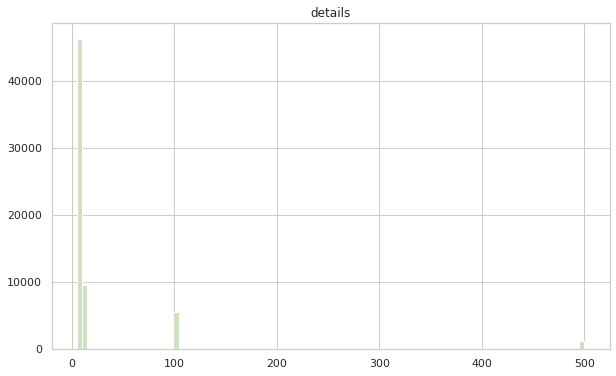

In [99]:
events.hist(column='details', bins=100, figsize=(10, 6));

In [100]:
#уточним, что это за значения

events.details.unique()

array([ 99.99,   9.99,   4.99, 499.99,    nan])

In [101]:
#уточним, каким действиям соответствуют эти значения

events.groupby(['event_name', 'details'])['details'].count()

event_name  details
purchase    4.99       46362
            9.99        9530
            99.99       5631
            499.99      1217
Name: details, dtype: int64

Судя по полученным данным, все значения столбца `details` соответствуют стоимости покупок (purchase). Как мы помним, в этом столбце имеются и другие действия пользователей, а в датафрейме содержатся пропуски. Поскольку иные действия (логин, просмотр карточки и корзины) не требуют оплаты, значит, столбец details имеет отношение исключительно к столбцу с покупками. Следовательно, пропуски данных означают, что было совершено действие, не связанное с приобретением товара. 

'количество пропусков: 377577'

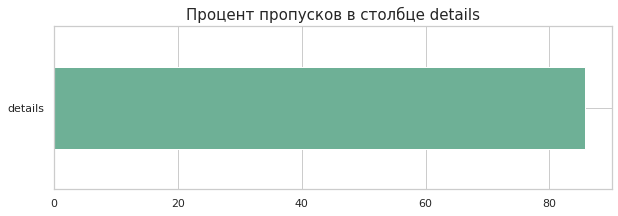

In [102]:
#уточним количество пропусков в столбце details

display(f"количество пропусков: {events['details'].isna().sum()}")

ax = (
    (events.isna().mean()*100)
    .to_frame()
    .rename(columns = {0:'space'})
    .query('space > 0')
    .sort_values(by = 'space', ascending = True)
    .plot(kind= 'barh', y='space', figsize=(10,3), legend = False,
         color=palette[5:])
    .set_title('Процент пропусков в столбцe details', fontsize=15)
     )

Согласно количеству пропусков, действия, не связанные с покупками, составляют более 80% от столбца.
Для возможности работы со столбцом заполним остальные данные "заглушкой", равной нулю.

In [103]:
#заполним пропуски в столбце details нулевым значением, чтобы использовать его для расчетов без ошибок

events['details'] = events['details'].fillna(0)

#проверим результат

events['details'].isna().sum()

0

<a id="first_conclusion"> </a>
### Вывод по этапу

Получены основные характеристики датасетов, выявлено отсутствие нарушения стиля в наименовании столбцов, отсутствие явных дубликатов в датафреймах, выявлены более 1,6 тыс. дубликатов в столбце user_id в датафрейме `participants`, а также факт нахождения одних и тех же пользователей в двух тестах (с преобладанием группы А), ряд столбцов с датой и временем приведен к временному типу, обнаружены пропуски в столбце `details`, заполнены нулевым значением ввиду соответствия неденежным категориям действий. 

<a id="ab_estimation"> </a>
## Оценка корректности проведения теста

<a id="specification_check"> </a>
### Проверка соответствия требованиям технического задания, пересечения с маркетинговыми событиями и другим тестом

Техническое задание включает в себя следующие пункты:
- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.
    
Пройдем по каждому из пунктов.
Как мы убедились выше, тест `recommender_system_test` присутствует в числе тестов, имеется разделение на две группы А и В. 

In [104]:
#создадим отдельную переменную, куда войдет только тест recommender_system_test

rec_test = participants.query('ab_test == "recommender_system_test"')
rec_test.head(5)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


Проверим даты запуска, остановки набора и остановки теста. По информации из технического задания мы должны получить следующие показатели:
- в датафрейме `users` имеются id пользователей, зарегистрировавшихся с 7 по 21 декабря 2020 года;
- датафрейм `events` содержит события с 7 декабря 2020 по 4 января 2021 года.

Убедимся, что фактические периоды в датафреймах совпадают с описанием.

In [105]:
#убедимся, что датасеты охватывают необходимый период времени

for df in df_dict:
    for column in df_dict[df].columns:
        if column in time and column not in ['start_dt', 'finish_dt'] :
            min_t = min(df_dict[df][column].dt.date)
            max_t = max(df_dict[df][column].dt.date)
            display(f"таблица {df}, столбец {column}, охватываемый период: с {min_t} по {max_t}")

'таблица events, столбец event_dt, охватываемый период: с 2020-12-07 по 2020-12-30'

'таблица users, столбец first_date, охватываемый период: с 2020-12-07 по 2020-12-23'

Ни один датафрейм не совпал с заявленным описанием. В датафрейме `users` оказались пользователи с более поздней датой регистрации (23, а не 21 декабря), в а `events` - совершившие действия только до конца декабря, а не до 4 января 2021 года. И если мы можем убрать лишних пользователей, зарегистрировавшихся после окончания набора, то восполнить отсутствующие данные не представляется возможным. Вероятно, при выгрузке данных произошла ошибка. 

In [106]:
#исключим из датафрейма users пользователей, зарегистрировавшихся после окончания набора на тест

users_test_period = users.query('first_date <= "2020-12-21"')
users_test_period.head(5)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [107]:
#проверим, насколько сократился датасет

display(f'изначальное число пользователей: {len(users)}')
display(f'после удаления: {len(users_test_period)}')
display(f'разница: {len(users) - len(users_test_period)}')

'изначальное число пользователей: 61733'

'после удаления: 56470'

'разница: 5263'

Новый датасет без пользователей, зарегистрировавшихся после 21 декабря, составил около 56,5 тысяч пользователей: на 5 тысяч меньше, чем ранее.

In [108]:
#добавим данные по дате регистрации участников теста 

rec_test = rec_test.merge(users_test_period, on='user_id', how='left')
rec_test.head(5)

,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac
3,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone
4,482F14783456D21B,B,recommender_system_test,2020-12-14,EU,PC


Проверим географию пользователей. По техническому заданию, аудитория датасета должна составлять 15% новых пользователей из европейского региона.

In [109]:
#проверим, входят ли в тестовые группы только пользователи из стран Европы

rec_test.groupby('region')['user_id'].count()

region
APAC           72
CIS            55
EU           6351
N.America     223
Name: user_id, dtype: int64

Большая часть тестовой группы действительно принадлежит европейскому региону, однако, в тест попала некая часть пользователей из Северной Америки, Азиатско-Тихоокенского региона и СНГ. 

In [110]:
#удалим из датафрейма пользователей не из ЕС

display(f'размер таблицы до удаления: {rec_test.shape[0]}')
rec_test = rec_test.query('region == "EU"')  
display(f'размер таблицы после удаления: {rec_test.shape[0]}')

'размер таблицы до удаления: 6701'

'размер таблицы после удаления: 6351'

In [111]:
#проверим, какой процент составляет группа участников теста от пользователей из ЕС

eu_pcnt = round(rec_test.shape[0] /\
                users_test_period.query('region == "EU"').shape[0] * 100, 1)
display(f'участников теста от новых пользователей из ЕС: {eu_pcnt}%')

'участников теста от новых пользователей из ЕС: 15.0%'

Требования по географии участников теста соблюдены: в группе присутствует 15% от новых пользователей из европейского региона.
Согласно техническому заданию, ожидаемое количество участников теста должно равняться 6000. Уточним еще раз, какое количество пользователей вошло в итоговую таблицу по итогам корректировки региона и даты регистрации.

In [112]:
display(f'Количество пользователей в тесте: {len(rec_test)}')

'Количество пользователей в тесте: 6351'

Количество пользователей на 351 человек превышает значение ТЗ. Придержимся логики, что чем больше данных, тем точнее результаты и оставим пользователей. Вероятно, мы вернемся к вопросу о численности теста после сравнения двух групп на равномерность.

In [113]:
#добавим к датафрейму информацию о действиях пользователей

rec_test = rec_test.merge(events, on='user_id', how='left')
rec_test.head(5)

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:56,purchase,4.99
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,0.00
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:57,product_cart,0.00
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,0.00


In [114]:
#добавим столбец с датой 

rec_test['dt'] = rec_test['event_dt'].dt.date

In [115]:
#проверим, все ли пользователей совершали действия 

display(rec_test['user_id'].nunique())
rec_test.isna().sum()

6351

user_id          0
group            0
ab_test          0
first_date       0
region           0
device           0
event_dt      2870
event_name    2870
details       2870
dt            2870
dtype: int64

Треть пользователей не совершали тех или иных действий.
Проверим распределение по группам таких пользователей.

In [116]:
#создадим отдельную переменную, куда вынесем id пользователей с пропущенными значениями

nan_users = rec_test[rec_test['event_name'].isna()]['user_id']


#сгруппируем пользователей, у которых есть пропуски по действиям
#если кроме пропусков будет совершено действие - это отобразится в группировке

rec_test.query('user_id in @nan_users').groupby('group')['user_id'].count()

group
A    1030
B    1840
Name: user_id, dtype: int64

Среди пользователей, не совершивших действий, заметно преобладание участников группы В - 1840 пользователя против 1030.
Выявим причину пропусков.

In [117]:
#добавим столбец с данными по пропускам

rec_test['na'] = rec_test['event_name'].isna()
rec_test.head(3)

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,dt,na
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99,2020-12-07,False
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:56,purchase,4.99,2020-12-25,False
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,0.00,2020-12-07,False


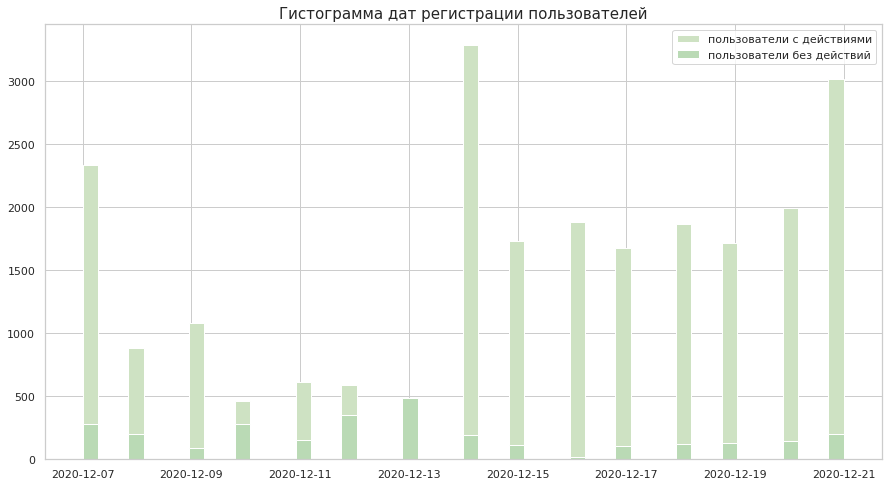

In [118]:
#сравним распределение по датам регистрации пользователей с действиями и без

ax = rec_test.query('na == False').hist(column='first_date', bins=50, figsize=(15,8))
rec_test.query('na == True').hist(column='first_date', bins=50, figsize=(15,8), ax=ax)
plt.legend(labels=['пользователи с действиями', 'пользователи без действий'])
plt.title('Гистограмма дат регистрации пользователей', fontsize=15);

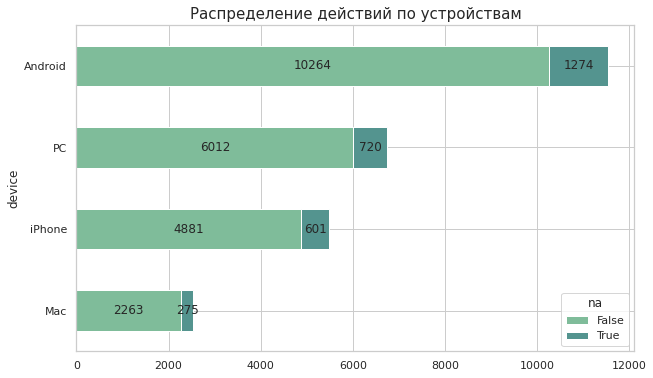

In [119]:
#уточним, с каких устройств заходили пользователи 

pivot = (
        rec_test
        .pivot_table(index='device', 
                     columns='na', 
                     values='user_id', 
                     aggfunc='count')
        .sort_values(by=0)
    )
    


ax = pivot.plot(kind='barh', 
                figsize=(10,6),
                stacked=True, 
                color=[palette[4], palette[7]])

ax.set_title('Распределение действий по устройствам', fontsize=15)
for p in ax.patches:
  width, height = p.get_width(), p.get_height()
  x, y = p.get_xy() 
  ax.text(x+width/2, 
                y+height/2, 
                '{:.0f}'.format(width), 
                horizontalalignment='center', 
                verticalalignment='center');

Чуть менее половины пользователей, которые не совершали действий, заходили через устройства на Android. Однако, это статистика не слишком отличается в своих пропорциях от распределения пользователей, которые совершали действия, а, следовательно, нельзя однозначно объяснить пропуски проблемами с работой сайта/приложения на той или иной платформе. Зато гистограммы по дате регистрации показали интересную особенность: бездействующие пользователи в основной массе регистрировались до середины декабря, в то время как активные - во второй половине месяца. 
Соответственно, объяснение этой причины может лежать или в изменениях в работе сайта (например, устранение неполадок, появление новых товаров) или возникновение интересных маркетинговых предложений после 15 декабря, которые стимулировали пользователей проявлять активность. 

In [120]:
#проверим, были ли маркетинговые события в декабре, и если да - после какого числа

december_events = (
    schedule
    .query('finish_dt > "2020-12-01" and regions.str.contains("EU")', engine="python")
)

december_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


В декабре найдено одно событие, которое актуально для европейского региона: Рождественское и новогоднее промо, запуск которого состоялся 25 декабря. Однако, данные за этот период частично не попали в датасет. 

Таким образом, определим возможные причины бездействия пользователей:
- во второй половине декабря произошли изменения в работе сервиса, что позволило привлечь более заинтересованных в пользователей (например, починка сайта или отдельных его функций, изменение дизайна и т.д.)
- проведение в первой половине декабря предварительной рекламы или акции: например, пользователям предлагалось зарегистрироваться заранее, чтобы получить скидку, не пропустить какое-то событие и т.д., но, в конечном итоге, эти пользователи ограничились лишь регистрацией и больше не заходили на сайт;
- также рассмотрим вариант, что эти пользователи также попали во второе исследование, из-за чего возникла ошибка - однако, у нас нет сведений о времени проведения второго теста.

In [121]:
#выведем число пользователей без действий, которые попали в другой тест

len(participants.query('ab_test == "interface_eu_test" and user_id in @nan_users'))

715

Четверть пользователей, не совершивших действие, вошли в число участников второго теста. Следовательно, нельзя однозначно утверждать, что проблема заключается в этом. 

Участники теста `recommender_system_test`, не совершившие действий, не требуются нам для анализа, так как по ним отсутствуют необходимые данные. Удалим их из датафрейма и проверим число пользователей получившейся таблицы. 

In [122]:
rec_test = rec_test[~rec_test['event_name'].isna()]

display(f'новое число участников теста: {rec_test.user_id.nunique()}')

'новое число участников теста: 3481'

In [123]:
#выявим отклонение от технического задания

display('Отклонение от технического задания составляет:')
display(f'{6000 - rec_test.user_id.nunique()} пользователя')
eu_pcnt = round(rec_test.user_id.nunique() /\
                users_test_period.query('region == "EU"').shape[0] * 100, 1)
display(f'Доля от пользователей из ЕС: {eu_pcnt}%')

'Отклонение от технического задания составляет:'

'2519 пользователя'

'Доля от пользователей из ЕС: 8.2%'

Удаление пользователей значительным образом отразилось на выполнении условий технического задания: возник недобор 2,5 тысяч участников теста, доля от новых пользователей из ЕС которых составила 8,2% вместо положенных 15. Соответственно, соответствие техническому заданию на предыдущем этапе было лишь формальностью, которая не обеспечивала должных результатов теста.

Проверим повторно аудиторию теста. Ранее мы выяснили, что у нас отсутстуют пользователи, участвующие одновременно в обеих группах, однако имеются клиенты. попавшие одновременно в оба теста. Проверим, сколько их осталось после обработки данных.

In [124]:
#проверим наличие одних и тех же пользователей в разных тестах

common_users_tests = (
    set(rec_test['user_id'])
    .intersection(set(participants
                      .query('ab_test != "recommender_system_test"')['user_id']))
)

display(f'общих пользователей: {len(common_users_tests)}')
display(f'% от теста: {round(len(common_users_tests) / rec_test.user_id.nunique() * 100, 1)}')

'общих пользователей: 887'

'% от теста: 25.5'

Количество общих пользователей равно 887 человек или 25% от рассматриваемого теста. Одним из критериев успешного A/B теста является участие его пользователей только в одном исследовании: если параллельно пользователь включен в другой тест, вполне возможно влияние одних тестовых действий на другие (например, пользователю показывается другая версия сайта в рамках второго теста и он решает купить тот или иной продукт, который оценивается в первом тесте). Мы не знаем деталей теста `interface_eu_test`, однако, согласно его названию, мы можем предположить, что он так или иначе связан с интерфейсом сайта/приложения, в то время как наш тест подразумевает оценку системы рекомендаций. Следовательно, между вторым и первым тестами могут иметься противоречия. В идеале таких пользователей необходимо удалить, однако, как мы уже понимаем, тестирование уже на текущий момент имеет множество противоречий, и, кроме того, мы не знаем подробностпй второго теста. Проверим также остальные параметры, которые могут влиять на выполнение ТЗ и примем решение об удалении таких пользователей.

Еще одним фактором, который может повлиять на чистоту проведения теста, является совпадение с его проведением маркетинговых мероприятий. Как мы выявили ранее, в конце декабря действительно начиналась предновогодняя акция. Выведем еще раз информацию о ней и времени проведения.

In [125]:
#выводим информацию

december_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


Декабрьская промо-акция начиналась 25 декабря и заканчивалась 3 января, совпадая, таким образом, со значительным периодом теста (который, по условиям, должен был проходить с 7 декабря по 4 января). 
В то же время, как показали результаты выше, у нас имеется не весь объем данных: максимальная дата совершения действий приходится на 30 декабря. 

In [126]:
#уточним, как много пользователей совершали действия после 24 декабря

display(f'пользователей:', rec_test.query('event_dt > "2020-12-24"')['user_id'].nunique())
'от событий: {:.2%}'.format(rec_test.query('event_dt > "2020-12-24"')['user_id'].nunique() /\
                            rec_test['user_id'].nunique())

'пользователей:'

1462

'от событий: 42.00%'

После 25 декабря почти 1,5 тыс. пользователи или 42% от данных совершили те или иные действия.

In [127]:
#внесем id пользователей в отдельную переменную

id_after_promo = rec_test.query('event_dt > "2020-12-24"')['user_id'].unique()

In [128]:
#уточним, какой объем приходится на действия после 24 декабря

display('действий:', len(rec_test.query('event_dt > "2020-12-24"')))
'от событий: {:.2%}'.format(len(rec_test.query('event_dt > "2020-12-24"')) /\
                            rec_test.shape[0])


'действий:'

4163

'от событий: 17.78%'

События, которые совершили пользователи после 24 декабря, составляют 18% от объема теста.  Проверим, повлияли ли распродажи на совершение действий пользователей.

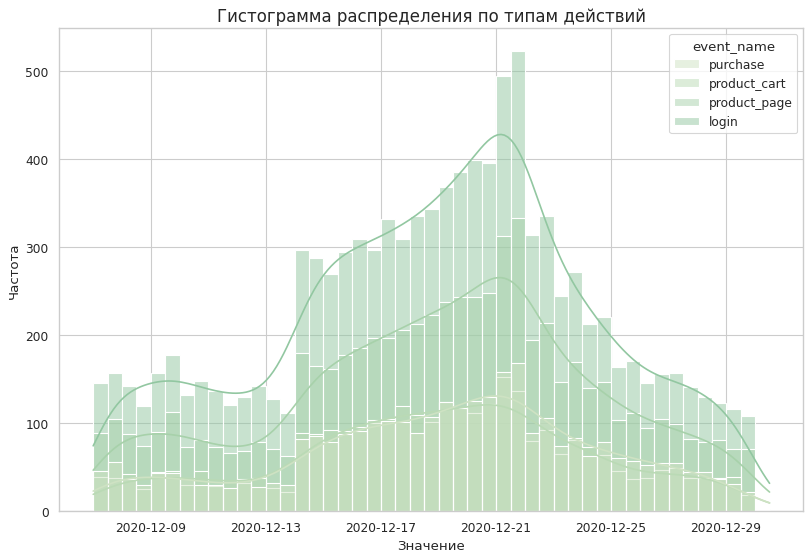

In [129]:
#построим гистограммы по каждому типу действий

plt.figure(figsize=(12, 8), dpi=80)
sns.histplot(data=rec_test, x='event_dt', hue='event_name', color=palette[6:10], kde=True)
plt.title('Гистограмма распределения по типам действий', fontsize=15)
plt.xlabel('Значение')
plt.ylabel('Частота');

По всей видимости, участники теста успели сделать покупки заранее - значительный рост всех действий начался 14 декабря, пиковое значение пришлось на 21 декабря, после чего наметилось снижение. 

In [130]:
#проверим, насколько большие пересечения между группами пользователей
#которые не соответствуют требования ТЗ

wrong_users = {'common_users': common_users_tests, 
               'promo': id_after_promo}

for k in wrong_users:
    display(f'пользователей в {k}: {len(wrong_users[k])}')

intrs = len(set(common_users_tests).intersection(set(id_after_promo)))
display(f'пересечений: {intrs} ')
'соотношение: {:.2%}'.format(len(common_users_tests) / len(id_after_promo))


'пользователей в common_users: 887'

'пользователей в promo: 1462'

'пересечений: 377 '

'соотношение: 60.67%'

Пользователи из пересекающихся групп составляют довольно большой объем данных от участников теста, действия которых были совершены в период промоакций - 60%.

In [131]:
#проверим, как изменится объем данных, если мы исключим все эти проблемные группы
#сохраним старые параметры

previous_nusers = rec_test['user_id'].nunique()
previous_nevents = rec_test.shape[0]


clear_test = rec_test.query('user_id not in @common_users_tests and user_id not in @id_after_promo')

next_nusers = clear_test['user_id'].nunique()
next_nevents = clear_test.shape[0]


In [132]:
display(f'новое число участников теста: {next_nusers}, событий: {next_nevents}')
display('% от предыдущих пользователей: {:.2%}'.format(next_nusers / previous_nusers))
display('% от событий: {:.2%}'.format(next_nevents / previous_nevents))   

'новое число участников теста: 1509, событий: 8650'

'% от предыдущих пользователей: 43.35%'

'% от событий: 36.93%'

Очистка данных позволила удалить более половины пользователей и значительную частью событий, которые противоречат техническому заданию. Выделение частичных срезов (например, удаление только пересекающихся пользователей), на наш взгляд, не имеет смысла, так как все спорные пользователи попадают под влияние тех или иных факторов. В то же время, их удаление сократило ожидаемое количество участников теста в четыре раза. 

Проверим, различаются ли наши два по группировке участников и ожидаемому результату. 

In [133]:
#уточним размеры и доли групп для предыдущей версии датафрейма

display(rec_test.groupby('group')['user_id'].nunique())
round(rec_test.groupby('group')['user_id'].nunique()/ rec_test.user_id.nunique() * 100)

group
A    2604
B     877
Name: user_id, dtype: int64

group
A    75.0
B    25.0
Name: user_id, dtype: float64

In [134]:
#уточним размеры и доли групп для новой версии

display(clear_test.groupby('group')['user_id'].nunique())
round(clear_test.groupby('group')['user_id'].nunique()/ clear_test.user_id.nunique() * 100)

group
A    1057
B     452
Name: user_id, dtype: int64

group
A    70.0
B    30.0
Name: user_id, dtype: float64

Одним из условий проведения A/B теста является равномернось всех участвующих групп. Различие в числе пользователей не должно превышать более 1%. В нашем случае значительная диспропорция видна невооруженным глазом: в предыдущей версии теста пользователей в группе А ровно в три раза больше, чем в группе В. Такой тест явно нельзя считать корректным. Эти пропорции чуть более сглажены в обновленной версии, однако разрыв по-прежнему велик - группа А превышает более чем в два раза группу В.

Наконец, проверим последнее условие технического задания: 
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

Для чистоты эксперимента проверим эти данные как на предыдущей версии теста, так и на новой. 
Так как нас интересует конверсия за 14 дней, исключим из датафреймов все действия, которые совершались пользователи на 15 день и далее. 

In [135]:
#добавим в каждую из таблиц столбец с данными по промежутку времени между регистрацией и действием

rec_test['diff'] =  (rec_test['event_dt'] - rec_test['first_date']).dt.days
clear_test['diff'] =  (clear_test['event_dt'] - clear_test['first_date']).dt.days

display(rec_test.head(5))
clear_test.head(5)

/tmp/ipykernel_48/3010951812.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,dt,na,diff
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99,2020-12-07,False,0
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:56,purchase,4.99,2020-12-25,False,18
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,0.00,2020-12-07,False,0
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:57,product_cart,0.00,2020-12-25,False,18
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,0.00,2020-12-07,False,0


,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,dt,na,diff
45,7473E0943673C09E,A,recommender_system_test,2020-12-16,EU,iPhone,2020-12-16 10:31:31,product_page,0.00,2020-12-16,False,0
46,7473E0943673C09E,A,recommender_system_test,2020-12-16,EU,iPhone,2020-12-19 03:12:25,product_page,0.00,2020-12-19,False,3
47,7473E0943673C09E,A,recommender_system_test,2020-12-16,EU,iPhone,2020-12-16 10:31:30,login,0.00,2020-12-16,False,0
48,7473E0943673C09E,A,recommender_system_test,2020-12-16,EU,iPhone,2020-12-19 03:12:25,login,0.00,2020-12-19,False,3
49,C46FE336D240A054,A,recommender_system_test,2020-12-17,EU,iPhone,2020-12-17 20:16:31,purchase,4.99,2020-12-17,False,0


In [136]:
#создадим функцию для вычисление таблицы с информацией о размерах групп 

def check_conversion(data):
    """Функция содержит код для построения таблицы по группам.

    Передаваемые на вход аргументы:
    data - датафрейм
    """
    
    steps = (data
          .pivot_table(index='event_name', columns='group', values='user_id', aggfunc='count')
          .rename(columns={'A': 'A_events', 'B': 'B_events'})
          )

    steps = (steps
          .join(data
                .pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique')
                .rename(columns={'A': 'A_users', 'B': 'B_users'}), on = 'event_name')
          )

    steps['range'] = [0, 2, 1, 3]
    steps = steps.sort_values(by='range').drop('range', axis=1)

    for i in steps.columns:
        steps[i + '_diff'] = steps[i].diff()


    return steps

In [137]:
#создадим функцию для построения воронки 

def funnel(steps, x1, x2, title):
    """Функция содержит код для построения 
    визуальной воронки конверсии.

    Передаваемые на вход аргументы:
    steps - сгруппированная таблица по А и В
    х1, х2 - параметры столбцов
    title - название воронки   
    """
    
    fig = go.Figure()
    fig.add_trace(go.Funnel(y=steps.index,
                            x=steps[x1],
                            name=x1,
                            textposition = "inside", 
                            textinfo = "value+percent previous",
                            opacity = 0.65, 
                            marker = {"color": "cadetblue"}))
    fig.add_trace(go.Funnel(y=steps.index,
                            x=steps[x2],
                            name=x2,
                            textposition = "inside", 
                            textinfo = "value+percent previous",
                            opacity = 0.65, 
                            marker = {"color": "wheat"},
                            connector = {"line": {"color": "white", 
                                                  "dash": "dot", 
                                                  "width": 3}}))
    fig.update_layout(title=f'Конверсия: {title}')
    fig.show()

In [138]:
#проверим, как много событий было совершено пользователями предыдущей версии

steps = check_conversion(rec_test.query('diff <= 14'))
steps

group,A_events,B_events,A_users,B_users,A_events_diff,B_events_diff,A_users_diff,B_users_diff
event_name,,,,,,,,
login,7968,2345,2604,876,NaN,NaN,NaN,NaN
product_page,5125,1257,1685,493,-2843.0,-1088.0,-919.0,-383.0
product_cart,2385,625,782,244,-2740.0,-632.0,-903.0,-249.0
purchase,2499,624,833,249,114.0,-1.0,51.0,5.0


In [139]:
#визуализируем данные по действиям 
funnel(steps, 'A_users', 'B_users', 'пользователи, неочищенные данные')

В предыдущей версии таблицы (без удаленных пользователей, которые оказались в обеих группах и совершали покупки в период промоакции) сложилась довольно необычная ситуация. На первых этапах обе группы демонстрировали нисходящую динамику, где:
- у группы А была достаточно неплохая конверсия из логина в просмотр карточки (65%), но более низкая конверсия на следуюшем этапе (просмотр корзины (46%);
- у группы В более низкая конверсия на первом этапе (56%), но чуть более высокий показать на этапе перехода в корзину по сравнению с группой А (49%).
Однако, уже последнем этапе конверсия неожиданно показала положительную динамику у группы А, где на страницу покупки перешло на 7% больше участников, чем тех, кто посещал корзину, а у группы В эта категория пользователей оказалась на 2% больше. 

Что касается изменения конверсии в отношении действий между группами, экспериментальная группа В показала положительную тенденцию только на одном этапе: переход со страницы в корзину (на 3% больше, чем у группы А). 


In [140]:
#проверим, как много событий было совершено пользователями новой версии

steps = check_conversion(clear_test.query('diff <= 14'))
steps

group,A_events,B_events,A_users,B_users,A_events_diff,B_events_diff,A_users_diff,B_users_diff
event_name,,,,,,,,
login,2813,1084,1057,452,NaN,NaN,NaN,NaN
product_page,1780,607,672,265,-1033.0,-477.0,-385.0,-187.0
product_cart,874,320,324,136,-906.0,-287.0,-348.0,-129.0
purchase,810,322,323,138,-64.0,2.0,-1.0,2.0


In [141]:
#визуализируем данные по очищенной группе 

funnel(steps, 'A_users', 'B_users', 'пользователи, очищенные данные')

Ситуация по очищенным данным несколько лучше: 

- во-первых, преобладание результатов конверсии группы В над группой А встречается уже на двух этапах: на этапе перехода к просмотру корзины (+3% - в посетителях у группы В), а также на этапе перехода из корзины к покупке (+1% пользователей);
- во-вторых, отрицательная разница между результатами группы А и В менее значительная, чем у неочищенного датафрейма (менее сильные разрывы).

В то же время, вновь присутствует положительная конверсия на финальном этапе, хотя вновь крайне высок процент действий.
Исходя из этого можно сделать следующие предположения, объясняющие данную ситуацию:
- сайт/приложение имеет особую структуру, которая позволяет напрямую переходить к странице покупки, минуя корзину;
- возникла ошибка системы, которая не учла логи пользователей в определенный момент нахождения в корзине;
- при выгрузке данных часть сведений не была учтена.

Несмотря на лучшие результаты у таблицы с участниками, данные по которым были очищены, тем не менее, **ни один показатель не был равен ожидаемому по ТЗ результату конверсии в не менее 10%**. 

<a id="second_conclusion"> </a>
### Вывод по этапу

Обобщив все результаты, для дальнейшего анализа мы возьмем предыдущую версию данных, куда входят посетители, попавшие в период распродажи и участвующие в двух тестах.
Аргументом за такое решение могут быть:
- не столь значительное отступление от ожидаемого числа участников теста (6000 человек) - менее двух раз, а не в четыре раза;
- не столь значительное групповое различие по сравнению с очищенным данными (разница в пользователях между группами А и В везде крайне велика и значительно превышает порог 1%);
- действия, которые могли бы быть скорректированы внешними факторами, такими как проведение другого теста или промоакции, одинаково влияют на пользователей из обеих групп, т.е. условия одинаковы: кроме того, данные показали, что новогодняя акция не способствовала значительному росту продаж и мы не знаем деталей второго теста;
- хотя участники из датасета с очищенными данными показали несколько лучшие результаты конверсии, ни одна из версий не продемонстрировала ожидаемый эффект по улучшению метрик;

В то же время:
- ни одна из версий данных также не соответствовала аудитории в 15% от новых пользователей из региона ЕС;
- ни одна из версий не соответствует временным параметрам событий;


Все указанное выше говорит о том, что **тест был проведен со значительными нарушениями и ни один из вариантов данных не удовлетворяет требованиям ТЗ**. 
В нашем случае нам придется выбрать лучший вариант из двух худших - и преимущество (по причинам, изложенным выше), на наш взгляд, остается за предпоследним вариантом данным с 3,5 тыс. участниками теста. 

<a id="eda"> </a>  
## Проведение исследовательского анализа данных

<a id="eda_events"> </a>  
### Распределение количества событий на пользователя в выборках

In [142]:
#выведем число пользователей 

rec_test['user_id'].nunique()

3481

In [143]:
#выведем еще раз сводную таблицу

steps = check_conversion(rec_test)
steps

group,A_events,B_events,A_users,B_users,A_events_diff,B_events_diff,A_users_diff,B_users_diff
event_name,,,,,,,,
login,8124,2471,2604,877,NaN,NaN,NaN,NaN
product_page,5227,1327,1685,493,-2897.0,-1144.0,-919.0,-384.0
product_cart,2422,653,782,244,-2805.0,-674.0,-903.0,-249.0
purchase,2536,660,833,249,114.0,7.0,51.0,5.0


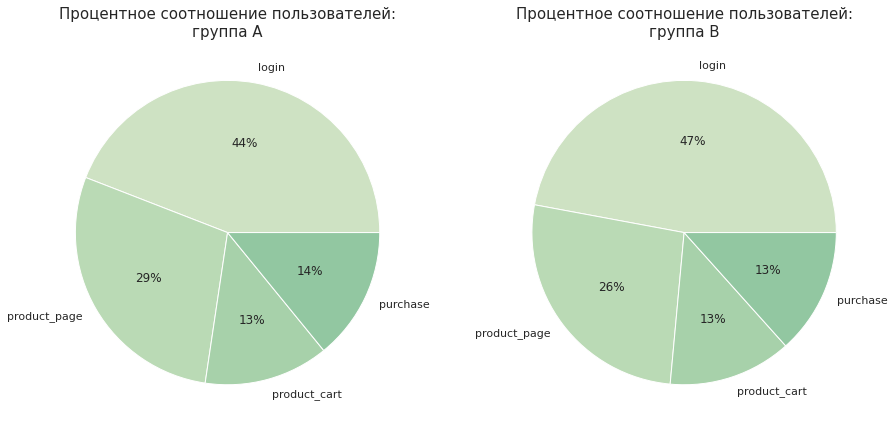

In [144]:
#строим круговую диаграмму по процентному соотношению пользователей

plt.figure(figsize=(15, 8))

ax1 = plt.subplot(1, 2, 1)
steps.plot(kind='pie',  y='A_users', autopct='%.0f%%', grid=True, legend=False, colors=palette, ax=ax1)
ax1.set_title(f'Процентное соотношение пользователей:\nгруппа А', fontsize=15)
plt.ylabel('')

ax2 = plt.subplot(1, 2, 2)
steps.plot(kind='pie',  y='B_users', autopct='%.0f%%', grid=True, legend=False, colors=palette, ax=ax2)
ax2.set_title(f'Процентное соотношение пользователей:\nгруппа В', fontsize=15)
plt.ylabel('');

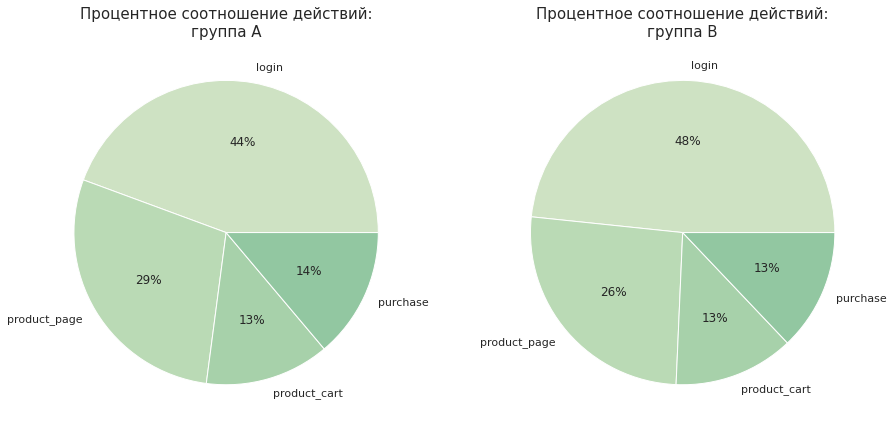

In [145]:
#строим круговую диаграмму по процентному соотношению событий

plt.figure(figsize=(15, 8))

ax1 = plt.subplot(1, 2, 1)
steps.plot(kind='pie',  y='A_events', autopct='%.0f%%', grid=True, legend=False, colors=palette, ax=ax1)
ax1.set_title(f'Процентное соотношение действий:\nгруппа А', fontsize=15)
plt.ylabel('')

#строим круговую диаграмму
ax2 = plt.subplot(1, 2, 2)
steps.plot(kind='pie',  y='B_events', autopct='%.0f%%', grid=True, legend=False, colors=palette, ax=ax2)
ax2.set_title(f'Процентное соотношение действий:\nгруппа В', fontsize=15)
plt.ylabel('');

Как мы установили ранее, группа А превышает численность группы В в три раза. Соответственно, единственным верным вариантом сравнения этих групп будет процентное соотношение. 
Распределение событий по уникальным пользователем выявило отсутствие особо значимых различий между двумя группами. Так, посещают страницу корзины и покупок около 13-14% пользователей в обеих группах. Однако, группа А несколько чаще предпочитает посещать страницу с описанием товара (29%), в то время как участники из группы В чаще посещают стартовую страницу (вход в систему) - 47%. Распределение именно по числу событий в целом соответствует этим данным за минимальным отличием в 1% в ряде случаев. 

In [146]:
#выявим, сколько в среднем событий приходится на пользователя

display('уникальных событий на пользователя:', rec_test.groupby('user_id')\
        .agg({'event_name': 'nunique'}).mean().round(2))

display('уникальных событий на участников группы А:', rec_test.query('group == "A"').groupby('user_id')\
        .agg({'event_name': 'nunique'}).mean().round(2))

display('уникальных событий на участников группы В:', rec_test
        .query('group == "B"').groupby('user_id')\
        .agg({'event_name': 'nunique'}).mean().round(2))

display('всего событий на пользователя:', rec_test
        .groupby('user_id')\
        .agg({'event_name': 'count'}).mean().round(2))

display('всего событий на участников группы А:', rec_test.query('group == "A"')
        .groupby('user_id')\
        .agg({'event_name': 'count'}).mean().round(2))

display('всего событий на участников группы В:', rec_test.query('group == "B"')
        .groupby('user_id')\
        .agg({'event_name': 'count'}).mean().round(2))

'уникальных событий на пользователя:'

event_name    2.23
dtype: float64

'уникальных событий на участников группы А:'

event_name    2.27
dtype: float64

'уникальных событий на участников группы В:'

event_name    2.12
dtype: float64

'всего событий на пользователя:'

event_name    6.73
dtype: float64

'всего событий на участников группы А:'

event_name    7.03
dtype: float64

'всего событий на участников группы В:'

event_name    5.83
dtype: float64

Всего на каждого пользователя приходится два действия - предположим, что в их число входят наиболее популярные авторизация и просмотр страницы. В группе А это значение несколько больше, чем в группе В. Аналогичноая ситуация и с общим числом событий: на каждого участника теста приходится около 6.7 действий, в то время как участники группы А совершают чуть более 7, а группа В не достигает показателя в 6 событий. Все это говорит о том, что контрольная группа А проявляет большую активность по сравнению с другой тестовой группой.

<a id="eda_dates"> </a> 
### Распределение числа событий по дням

In [147]:
#создадим сводную таблтцу по дням

days = (rec_test
          .pivot_table(index='dt', 
                       columns='group', 
                       values='user_id', 
                       aggfunc='count')
          .rename(columns={'A': 'A_events', 
                           'B': 'B_events'})
)

days.head(5)

group,A_events,B_events
dt,,
2020-12-07,318.0,356.0
2020-12-08,313.0,238.0
2020-12-09,371.0,338.0
2020-12-10,331.0,249.0
2020-12-11,356.0,161.0


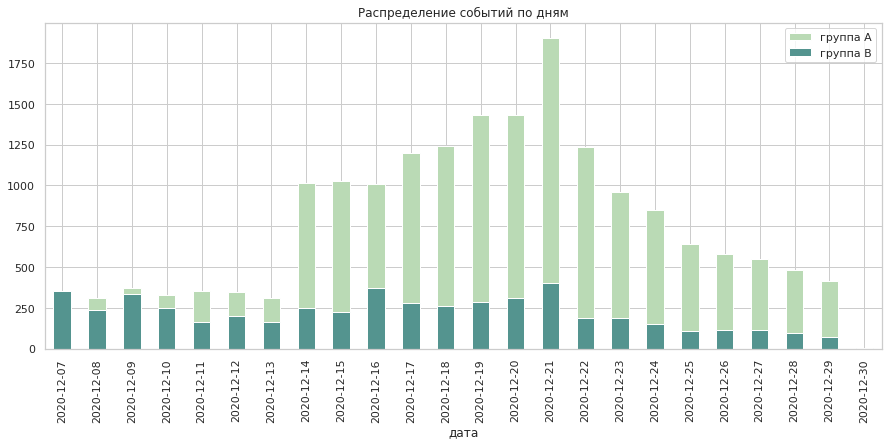

In [148]:
#выведем на график распределение событий по дням для каждой из групп

ax =  (days.plot(kind='bar', y='A_events', 
                 color=palette[1], 
                 label='группа А')
      )

(
    days
    .plot(kind='bar', y='B_events',
            title='Распределение событий по дням',
            color=palette[7], figsize=(15, 6), 
          label='группа В', 
          ax=ax, xlabel='дата')
);

Как мы видим на диаграмме, ситуация менялась с течением времени как в рамках каждой из групп, так и в соотношении между ними. Так, в первые несколько дней количество событий в группе В превалировало или было близком к количеству событий группы А. После небольшого спада, с 14 декабря действия пользователей группы В зафиксировались примерно на одном уровне с двумя пиковыми значениями 16 и 21 декабря, после чего резко снизились и продолжили едва заметное снижение до конца месяца. Группа А, напротив, распределена несколько иначе, с особо выраженным пиковым значением 21 декабря. Пользователи этой группы начали проявлять резкую активность 14 декабря, и сразу после этой даты начали плавное снижение числа своих действий. 

Таким образом, обе группы похожи в своих действиях в отношении периода после 23 декабря включительно (снижение активности), в то время как в начале периода лидировала группа В, между этими датами активность в группе В была более умеренной, а у группы А - возрастающей. 

Наличие особой активности 21 декабря (в день, когда завершался набор в тестируемые группы) говорит о возможном проведении акции, распродажи или иного другого стимулирующего события, о котором нам неизвестно.

Посмотрим на распределение категорий событий для каждой из групп по дням

In [149]:
def plotly_bar(data, x, y, text, title, xaxis, yaxis):
    """Функция содержит код для построения 
    интерактивного распределения.

    Передаваемые на вход аргументы:
    data - сгруппированная таблица
    х, y - параметры столбцов
    title - название диаграммы
    xaxis, yaxis - подписи осей
    """
    plt.figure(figsize=(20, 15))
    fig = px.bar(data, 
             x=x, 
             y=y, 
             text=text, 
             color=text, 
             color_discrete_sequence=['#cee2c3',
                                      '#a7d1aa',
                                      '#7fbc9a',
                                      '#5fa292',
                                      '#4a848b',
                                      '#3c617c',
                                      '#334064',
                                      '#26213f'])
    fig.update_layout(xaxis={'categoryorder': 'total descending'})
    fig.update_layout(title=title,
                       xaxis_title=xaxis,
                       yaxis_title=yaxis)
    return fig

In [150]:
#создадим таблицу, куда войдут данные по всем категориям действий

events_categories = (rec_test
             .groupby(['dt', 'group'])['event_name']
             .value_counts()
             .to_frame('count')
             .reset_index()
             .sort_values(by='count', ascending=False)
            )

events_categories.head(5)

,dt,group,event_name,count
112,2020-12-21,A,login,837
104,2020-12-20,A,login,627
96,2020-12-19,A,login,617
120,2020-12-22,A,login,554
113,2020-12-21,A,product_page,549


In [151]:
#посмотрим на распределение событий для группы А

def plotly_bar(data, x, y, text, title, xaxis, yaxis):
    plt.figure(figsize=(20, 15))
    fig = px.bar(data, 
             x=x, 
             y=y, 
             text=text, 
             color=text, 
             color_discrete_sequence=['#cee2c3',
                                      '#a7d1aa',
                                      '#7fbc9a',
                                      '#5fa292',
                                      '#4a848b',
                                      '#3c617c',
                                      '#334064',
                                      '#26213f'])
    fig.update_layout(xaxis={'categoryorder': 'total descending'})
    fig.update_layout(title=title,
                       xaxis_title=xaxis,
                       yaxis_title=yaxis)
    return fig

In [152]:
#построим таблицу для группы А

plotly_bar(events_categories.query('group == "A"'),
           'dt', 
           'count', 
           'event_name', 
           'Распределение действий по датам: группа А', 
           'дата', 
           'значение')

<Figure size 1440x1080 with 0 Axes>

Для пользователей из группы А характерно преобладание в любой из дней такого действия, как авторизация на сайте, следом за которым идет посещение страницы продукта. Остальные два действия - посещение корзины и покупка - а целом равны по количеству обращений, с периодическим небольшим увеличением то одной, то другой категории.

In [153]:
#построим аналогичную таблицу для группы В

plotly_bar(events_categories.query('group == "B"'),
           'dt', 
           'count', 
           'event_name', 
           'Распределение действий по датам: группа B', 
           'дата', 
           'значение')

<Figure size 1440x1080 with 0 Axes>


Группа В не слишком отличается в распределении категорий посещения по датам: здесь также доминирует посещение стартовой страницы (логин), на которую приходится ежедневно около половина всех действий, второе по числу действий - посещение страницы товара. В наиболее пиковые даты пользователи несколько чаще заходят на страницу с товаром, в менее насыщенные дни с точки зрения посещения - предпочитают сразу переходить к покупке. 

<a id="eda_conv"> </a> 
### Изменение конверсии в воронке в выборках на разных этапах

На данном этапе мы вновь построим воронку событий. Однако, в отличие от предыдущего раза, мы обратим большее внимание на изменение конверсии в каждой из групп. 
Вновь ограничим наши данные участниками, которые успели провести в системе одинаковое время (т.е. 14 дней).


In [154]:
#вновь выведем таблицу steps

steps = check_conversion(rec_test.query('diff <= 14'))
steps[['A_users', 'B_users', 'A_users_diff','B_users_diff']]


group,A_users,B_users,A_users_diff,B_users_diff
event_name,,,,
login,2604,876,NaN,NaN
product_page,1685,493,-919.0,-383.0
product_cart,782,244,-903.0,-249.0
purchase,833,249,51.0,5.0


In [155]:
#визуализируем данны

funnel(steps, 'A_users', 'B_users', 'действия пользователей')

- На этапах перехода со страницы авторизации на на страницу продукта и со страницы продукта к корзине в группе А отсеялось почти одинаковое количество человек - более 900, в группе В эти значения отличаются в большую сторону;
- конверсия с первого на второй этап составила 65 у группы А и 56% у группы В;
- конверсия на следующем этапе больше у группы В - 49% против 46% у группы А, однако процент от изначальных пользователей выше у первой группы (30 и 28% соответственно);
- конверсия между переходами от корзины к странице покупки у обеих групп имеет более высокое значение, чем этапом ранее (что, как мы предположили, может говорить или о возможности перехода к оплате прямо со страницы товара, либо об ошибках на сайте), у группы А здесь показатели лучше - 107%, а также 32% от первого этапа (у группы В эти показатели равны 102 и 28%).

<a id="third_conclusion"> </a>
### Особенности данных перед проведением A/B-тестирования, вывод по разделу

Перед проведением А/B теста еще раз охарактеризуем наши данные и подведем выводы по разделу.
По итогам исследования и очистки данных мы получили следующую картину:
- 3481 уникальных пользователей, из которых в группе А - 2604 человека, в группе В - 877 (соотношение: 1 к 3);
- большая часть действий в обеих группах приходится на авторизацию (44%), далее идет посещение страницы продукта (29%), примерно одинаковые доли приходятся на покупки и корзину; разница в этих показателях между группами незначительна (не более 4%);
- всего на пользователя приходится 2.23 уникальных события и 6.7 событий в среднем, для группы А эти доли несколько больше, для группы В - меньше;
- наибольшая активность по дням приходится на середину исследуемого периода с пиковым значением 21 декабря, активность группы А более резкая, у В - более равномерная, особенно, до 20х чисел;
- для обеих групп в целом характерно пропорциональное распределение тех или иных действий в любые из дней (лидерство за авторизацией, просмотр страницы и попеременное преобладание то просмотра корзины, то страницы оплаты);
- группа А отличается лучшей конверсией при переходе с 1 на 2 действие и с 3 на 4, единственное преобладание у категории В - конверсия при переходе со страницы продукта в корзину, практически все процентные показатели по воронке лучше у группы А.

**Для успешного проведения A/B теста необходимы следующие условия**:

- количество пользователей в различных группах различается не более, чем на 1% - *условие не соблюдено*, крайне высокое различие;
- различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости - *условие частично соблюдено:* процентное соотношение в разделении по событиям довольно близкое, однако имеется различие по активностям в те или иные даты, а также конверсии;
- попавший в одну из групп посетитель остаётся в этой группе до конца теста - *условие соблюдено*, пользователей, которые находятся одновременно в двух группах, нет.

<a id="results"> </a>
## Оценка результатов A/В-тестирования

<a id="ab_results"> </a>
### Выводы о характере результатов A/В теста

По итогам проведенного выше анализа можно сделать следующие выводы о характере результатов тестирования.

На наш взгляд, **результаты не являются достоверными по следующим причинам**.

1) **Неполнота данных по сравнению с требованиями ТЗ**. Это и отсутствие данных с 30 декабря по 4 января (из-за чего сократилось число пользователей, чей потенциальный лайфтайм равен 14 дням, и большое количеств о бездействующих пользователей в изначальном датафрейме. Все это привело к тому, что ожидаемое число участников теста снизилось с 6000 до 3500, т.е. почти в 2 раза. 

2) **Значительное неравенство между двумя тестовыми группами**. В идеальном тесте различие не должно превышать 1%, однако, в нашем случае контрольная группа А в три раза больше экспериментальной группы В. Соответственно, выборки неоднородные по своему характеру. 

3) **Неудачный временной промежуток для тестирования**. Во-первых, пересечение с новогодней акцией: хотя она не сильно отразилась на действиях в обеих группах (и у группы А, и у группы В заксировано снижение после 24 декабря), тем не менее, идеальный тест должен проходить без вмешательства внешних факторов, которые могут повлиять на его результаты. Кроме того, имеется подозрение на проведение 21 декабря (в день финального включения пользователей в тест) каких-либо распродаж или прочих акций, что объясняет небывалый рост активности в группе А, а также пиковое значение (пусть и не столь высокое) в группе В. Кроме того, обе группы различаются по своему стартовому положению: в начале проведения теста группа В проявляла куда большую активность, чем группа А, после чего у группы А начался резкий рост.

4) **Наличие ряда пользователей в параллельном тесте**: как мы выяснили, значительное число пользователей одновременно принимало участие во втором тесте, подробности которого нам неизвестны. Учитывая, что участники были из обеих групп, мы не стали удалять таких пользователей, однако, параллельные тестирования не должны проводиться, чтобы не повлиять на чистоту результатов. 

5) **Тестирование не показало ожидаемых результатов касательно увеличения метрик группы В**. Более того, конверсионная последовательность неоднородна: на последнем этапе в обеих группах больше пользователей, чем на предыдущем. Если это не вызвано ошибкой, об этом нужно указывать информацию в ТЗ (чтобы рассматривать иные варианты конверсии).

6) **Наличие мусорных данных в исходных данных о тестировании**: таких, как пользователи из другого региона, пользователи с более поздней регистрацией. 

7) **Формальный подход к проведению тестирования, допущение ошибок при работе с данными**: при первом взгляде на данные у нас имелось соответствие ТЗ (количество пользователей, % от европейцев), которое было опровергнуто после более детального знакомства с датафреймами. 

7) **Потенциальные технические проблемы, в том числе с которыми столкнулась группа В**: именно на нее приходится большой процент пропусков активности, особый рост активности в первые дни и прочие странности.

Тестирование не соответствует ТЗ в целом: как видно из описания выше, многие пункты не были соблюдены, следовательно, **полученные результаты не отображают поставленных перед тестом задач**. Рекомендуется провести новое тестирование, обратив особое внимание на качество и характер данных.

<a id="test_st_diff"> </a>  
### Проверка статистической разницы долей z-критерием

In [156]:
#еще раз вызовем функцию для создания переменной, в которую войдут данные о событиях всех групп

steps = check_conversion(rec_test)
steps = steps[['A_users', 'B_users', 'A_users_diff','B_users_diff']]
steps

group,A_users,B_users,A_users_diff,B_users_diff
event_name,,,,
login,2604,877,NaN,NaN
product_page,1685,493,-919.0,-384.0
product_cart,782,244,-903.0,-249.0
purchase,833,249,51.0,5.0


Сравнение пропорций двух генеральных совокупностей осуществим по выборкам из них путем проверки гипотезы о равенстве долей посредством Z-теста. Для проведения теста мы будем использовать доли клиентов, совершивших то или иное событие, от общего числа уникальных пользователей в группе.

Сформулируем общие гипотезы:
- Н0 - статистически значимые различия между долями пользователей, совершивших то или иное действие, отсутствуют. 
- альтернативная гипотеза - имеются статистические различия между долями пользователей, совершивших то или ное действие.

Установим уровень статистической значимости теста на значение в 0.05. При уменьшении уровня статистической значимости снижается критический промежуток, при попадании в который нулевую гипотезу отвергают (увеличивается вероятность ошибки второго рода, т.е. возможность неверного принятия гипотезы). Мы предпочтем допустить ошибку первого рода и увеличить вероятность неверного отклонения верной гипотезы, однако, не будем сильно завышать уровень. Таким образом, уровень в 0.05 представляется наиболее подходящим вариантом. 

Также нам потребуется поправка Бонферрони, так как на одном наборе данных мы проводим три статистических теста.  

In [157]:
#cоздадим переменную, в которую включим все необходимые расчеты для получения p-value через величину Z.

def z_stat(next):
    previous = np.array(steps[['A_users', 'B_users']])[0]
    p1 = next[0]/previous[0]  
    p2 = next[1]/previous[1]
    p_combined = (next[0] + next[1]) / (previous[0] + previous[1])
    difference = p1 - p2 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/previous[0] + 1/previous[1]))
    distr = st.norm(0, 1) 
    alpha = 0.05 / 3
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value.round(3))
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

In [158]:
#пройдем с помощью цикла по всем значениям

for i in range(1, len(steps)):
    print(f"проверка события {steps.index[i]}")
    next_event = np.array(steps[['A_users', 'B_users']])[i]
    z_stat(next_event)
    print()

проверка события product_page
p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница

проверка события product_cart
p-значение:  0.215
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

проверка события purchase
p-значение:  0.047
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Согласно полученным результатам, мы отвергли только одну нулевую гипотезу о равенстве долей пользователей групп А и В, совершивших просмотр страницы продукта. Как мы помним из ранее проведенного исследования, действительно, пропорции между в этой категории между группами различались в наибольшей степени, в то время как в остальных были достаточно близки, что и подтвердили результаты z-теста. 

<a id="conclusion"> </a>

## Выводы

1) **Рассмотренное A/B тестирование признано неудачным ввиду большого числа ошибок**, таких как неполнота данных, неудачный временной промежуток, пересечение пользователей между тестами и с маркетинговыми событиями, наличие мусорных данных и возможных технических проблем, с которыми столкнулись пользователи, а также отсутствие ожидаемых метрик в 10%.
**Главные претензии к тесту**: 
- значительное неравенство тестируемых групп (75% в пользу А);
- допущение формального подхода к тестированию, где недостаточная проверка данных привела к ряду серьезных ошибок;
- отсутствие большого числа дополнительных данных (начиная от данных по действиям после 30 декабря, заканчивая описанием структуры сайта, возможностями перехода между страницами и т.д. для более точного вычисления конверсии);

2) Ввиду необходимости очистки данных была потерена значительная часть участников тестирования. **Полученные после обработки данные не соответствовали требованиям ТЗ**: из 6 тысяч участников в нашем распоряжении осталось всего около 3,5 тысяч человек, большинство пунктов ТЗ не были соблюдены. Соответственно, **полученные результаты не отображают поставленных перед тестом задач заказчиком**. Его результаты могут быть использованы в работе с осторожностью.

3) Проверка z-тестом показала, что **между долями пользователей групп А и В отсутствует значимое различие при совершении конверсий при переходе со страницы продукта на страницу корзины и из нее - на страницу покупки**. Это подтверждают и не столь значительные различия в воронке конверсии, где максимальное отличие приходится на первый этап воронки (от авторизации - к странице с товаром), а также близкие пропорции распределения действий пользователей по группам. 
Следовательно, учитывая все несовершенство теста и полученные результаты, **можно предположить, что новая система рекомендации, которая тестировалась на группе В, не оправдала себя на текущий момент или ее тестирование сопровождалось большим числом ошибок**, ввиду которых возникли проблемы с данными по этой группе. 

**Рекомендации**
- для выявления тех или иных закономерностей крайне рекомендуется **провести тестирование повторно, уделяя более значительное внимание отбору данных для проведения теста** и учитывая возможные факторы, которые будут влиять на него (маркетинговые события, другие тесты и т.д.);

- перед проведением А/B теста рекомендуется **провести предварительный А/А тест для проверки корректности полученных данных**;

- для более точной обработки данных рекомендуется **сообщать о структуре сайта**, возможности перехода между разделами и т.д. для выявления более точной конверсии;

- **провести проверку технической стороны работы сайта** с целью возможного выявления ошибок и их недопущения при дальнейших тестированиях.